In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
from matplotlib.colors import SymLogNorm

# Methodology

I will first define a set of functions that can be utilised to make the covariance calculation process more readable. I will then continue to use these to calculate the covariance matrix for the given fields / data vector before plotting the associated correlation matrix for a visual check.

## Utility Functions

In [2]:
def nmt_workspace_pick(covwsp, wsps, i, j):
    """
    Picks the appropriate NmtWorkspace based on the tracer indices i and j. Currently only desingned for two unique maps.
    I intend to generalise this to more maps in the future.
    
    Parameters
    ----------
    covwsp: NmtCovarianceWorkspace
		List of available covariance workspaces. In order [map1-map1, map1-map2, map2-map2]
    wsps: list of NmtWorkspace
        List of available workspaces. In order [map1-map1, map1-map2, map2-map2]
    i: int
        Index of the first tracer.
    j: int
        Index of the second tracer.
    
    Returns
    -------
    NmtWorkspace
        The selected workspace for the given tracer indices.
    """
    if i == 4 and j == 4:
        return covwsp[2], wsps[2]
    elif i == 4 and j < 4:
        return covwsp[1], wsps[1]
    elif j == 4 and i < 4:
        return covwsp[1], wsps[1]
    elif i < 4 and j < 4:
        return covwsp[0], wsps[0]
    else:
        print(f"Error: ({i}, {j}) is not a valid tracer combination.")

def covariance_to_correlation(cov):
    '''
    Converts a covariance matrix to a correlation matrix.
    
    Parameters
    ----------
    cov: numpy.ndarray
        Covariance matrix to convert.
    
    Returns
    -------
    corr: numpy.ndarray
        Correlation matrix corresponding to the input covariance matrix.
    '''
    v = np.sqrt(np.diag(cov))
    outer_v = np.outer(v, v)
    corr = cov / outer_v
    corr[cov  == 0] = 0  # Avoid division by zero
    return corr


# From Dr. Tom Cornish's code:

def compute_covariance(cw, wi, f_i1, f_i2, wj=None, f_j1=None, f_j2=None, f_sky=None):
	'''
	Computes the Gaussian covariance for a pair of angular power spectra,
	given the fields used to compute said spectra. 

	Parameters
	----------
	cw: pymaster.NmtCovarianceWorkspace
		Covariance workspace defined with all masks involved.

	wi: pymaster.NmtWorkspace
		NaMaster workspace defined with the mask involved in the first power spectrum.
	
	f_i1, f_i2: pymaster.NmtField, pymaster.NmtField
		Fields contributing to the first power spectrum.
	
	wj: pymaster.NmtWorkspace
		NaMaster workspace defined with the mask involved in the second power spectrum.
		If None, will be set to wi.
	
	
	f_j1, f_j2: pymaster.NmtField, pymaster.NmtField
		Fields contributing to the second power spectrum. If None, will be set
		to f_i1 and f_i2.
	
	f_sky: float
		Estimate of the observed sky fraction (assumed the same for all fields).
		If None, will calculate using the mask.
	
	Returns
	-------
	covar: numpy.ndarray
		Covariance matrix for the pair of angular power spectra.
	'''
	#see if additional fields have been provided for the second power spectrum
	if f_j1 is None:
		f_j1 = f_i1
	if f_j2 is None:
		f_j2 = f_i2
	#see if a separate workspace has been provided
	if wj is None:
		wj = wi
	
	#if no sky fraction estimate is provided, compute from mask
	if f_sky is None:
		f_sky_i1j1 = np.mean(f_i1.get_mask() * f_j1.get_mask())
		f_sky_i1j2 = np.mean(f_i1.get_mask() * f_j2.get_mask())
		f_sky_i2j1 = np.mean(f_i2.get_mask() * f_j1.get_mask())
		f_sky_i2j2 = np.mean(f_i2.get_mask() * f_j2.get_mask())

	
	#compute coupled c_ells for each possible combination of i and j
	cl_coupled_i1j1 = nmt.compute_coupled_cell(f_i1, f_j1)
	cl_coupled_i1j2 = nmt.compute_coupled_cell(f_i1, f_j2)
	cl_coupled_i2j1 = nmt.compute_coupled_cell(f_i2, f_j1)
	cl_coupled_i2j2 = nmt.compute_coupled_cell(f_i2, f_j2)
	#use these along with the mask to get a guess of the true C_ell
	cl_guess_i1j1 = cl_coupled_i1j1 / f_sky_i1j1
	cl_guess_i1j2 = cl_coupled_i1j2 / f_sky_i1j2
	cl_guess_i2j1 = cl_coupled_i2j1 / f_sky_i2j1
	cl_guess_i2j2 = cl_coupled_i2j2 / f_sky_i2j2


	covar = nmt.gaussian_covariance(cw, 
									0, 0, 0, 0,			#spin of each field
									[cl_guess_i1j1[0]],	
									[cl_guess_i1j2[0]],
									[cl_guess_i2j1[0]],
									[cl_guess_i2j2[0]],
									wi,
									wj)

	return covar

## NaMaster Fields + Workspaces

I define a NmtWorkspace and a NmtCovariance for each combination of mask used.

In [3]:
# Directory in which the maps are stored
path_maps = 'SkyMaps/GCxCIB/maps/'
# Load the HSC mask
mask_hsc = hp.read_map(path_maps + 'hsc_mask_nside1024.fits')
# Load the CIB mask
mask_cib = hp.read_map(path_maps + 'cib_mask_nside1024.fits')

nside = 1024

In [4]:
# Load all 4 HSC maps and store in a list
dg_maps = [hp.read_map(path_maps + f'hsc_zbin{i}_nside1024.fits') for i in range(4)]

# Load the CIB map
cib_map = hp.read_map(path_maps + 'cib_857micron_signal_nside1024.fits')

In [5]:
# NmtField for the HSC overdensity maps
f_dg = [nmt.NmtField(mask_hsc, [m]) for m in dg_maps]
# NmtField for the CIB map
f_cib = nmt.NmtField(mask_cib, [cib_map])

In [6]:
# Define bandpowers (we will use linearly spaced bins 40 multipoles wide)
b = nmt.NmtBin.from_nside_linear(nside, 40)
# Create NmtWorkspace
wsp_HSC_CIB = nmt.NmtWorkspace.from_fields(f_dg[0], f_cib, b)
wsp_HSC_HSC = nmt.NmtWorkspace.from_fields(f_dg[0], f_dg[1], b)
wsp_CIB_CIB = nmt.NmtWorkspace.from_fields(f_cib, f_cib, b)

#Define a covariance workspace
covwsp_HSC_CIB = nmt.NmtCovarianceWorkspace()
covwsp_HSC_CIB.compute_coupling_coefficients(f_dg[0], f_cib)

covwsp_HSC_HSC = nmt.NmtCovarianceWorkspace()
covwsp_HSC_HSC.compute_coupling_coefficients(f_dg[0], f_dg[1])

covwsp_CIB_CIB = nmt.NmtCovarianceWorkspace()
covwsp_CIB_CIB.compute_coupling_coefficients(f_cib, f_cib)

I choose to exclude the calculation of the angular power spectra here as they are not used in the final covariance calculation.

## Calculating Covariances and Constructing the Cov-Matrix

In [7]:
indices = [# All 10 HSC auto- and cross-correlations
    (0, 0), (0, 1), (0, 2), (0, 3),
            (1, 1), (1, 2), (1, 3),
                    (2, 2), (2, 3),
                            (3, 3),

    # The 4 HSC-CIB cross-correlations
    (0, 4), (1, 4), (2, 4), (3, 4),

    # The CIB auto-correlation
    (4, 4)]

block_matrix_list = [[None for _ in range(len(indices))] for _ in range(len(indices))]

In [8]:
'''
Data vector layout: (cl_g0g0, cl_g0g1, cl_g0g2, cl_g0g3, cl_g1g1, cl_g1g2, cl_g1g3, cl_g2g2, cl_g2g3, cl_g3g3, cl_cib_cib, cl_g0cib, cl_g1cib, cl_g2cib, cl_g3cib).T

This includes the following angular power spectra:
- HSC auto-correlations: cl_g0g0, cl_g1g1, ...
- HSC-CIB cross-correlations: cl_g0cib, cl_g1cib, ...
- CIB auto-correlation: cl_cib_cib

Note: g0, g1, ... refer to the HSC redshift bins (0, 1, 2, 3), and cib refers to the CIB map.

Covariance matrix layout:

| cov(cl_g0g0, cl_g0g0)  | cov(cl_g0g0, cl_g0g1)  | ... | cov(cl_g0g0, cl_g3cib)  | 
| cov(cl_g0g1, cl_g0g0)  | cov(cl_g0g1, cl_g0g1)  | ... | cov(cl_g0g1, cl_g3cib)  |
| ...                    | ...                    | ... | ...                     |
| cov(cl_g3cib, cl_g0g0) | cov(cl_g3cib, cl_g0g1) | ... | cov(cl_g3cib, cl_g3cib) |

'''

# Note: this code assumes that one only is working with two unique masks, but can be extended when nmt_workspace_pick is updated.

maps = [f_dg[0], f_dg[1], f_dg[2], f_dg[3], f_cib]

workspaces = [wsp_HSC_HSC, wsp_HSC_CIB, wsp_CIB_CIB]
covariance_workspaces = [covwsp_HSC_HSC, covwsp_HSC_CIB, covwsp_CIB_CIB]

for i in range(len(indices)):
    for j in range(i, len(indices)):
        i1, i2 = indices[i]
        j1, j2 = indices[j]

        #print(f"Computing covariance for indices ({i1}, {i2}) and ({j1}, {j2}) and index pair ({i}, {j})")

        covwsp1, wsp1 = nmt_workspace_pick(covariance_workspaces, workspaces, i1, i2)
        covwsp2, wsp2 = nmt_workspace_pick(covariance_workspaces, workspaces, j1, j2)

        # Ensure that the covariance workspace is selected correctly. This is done by noting that the HSC_CIB map is 
        # the most general map, including all HSC masks and the CIB masks. 
        if (covariance_workspaces.index(covwsp1) or covariance_workspaces.index(covwsp2)) == 1:
            covwsp = covariance_workspaces[1]
        else:
            covwsp = covariance_workspaces[max(covariance_workspaces.index(covwsp1), covariance_workspaces.index(covwsp2))]
        

        cov = compute_covariance(covwsp, wsp1, maps[i1], maps[i2], wj=wsp2, f_j1=maps[j1], f_j2=maps[j2])
        
        block_matrix_list[i][j] = cov
        if i != j:
            block_matrix_list[j][i] = cov.T

        
        
final_covariance = np.block(block_matrix_list)


The covaraince matrix has now been calculated and stored. For visualisation purposes I will plot its associated correlation matrix as a check that nothing has obviously gone wrong.

When calculating the correlation matrix I was getting some erroneous values that were significantly above one, often close to the block boundaries. To combat this I regularise the covariance matrix before calculating its correlation matrix.

In [9]:

def regularize_covariance(cov_matrix):
    """
    Forces a covariance matrix to be positive semi-definite by clipping
    its negative eigenvalues.

    Uses formula A = V * D * V^T, where V is the matrix of eigenvectors,
    D is the diagonal matrix of eigenvalues, and A is the covariance matrix.
    """

    # Ensure symmetry of the covariance matrix
    cov_sym = (cov_matrix + cov_matrix.T) / 2
    
    # Decompose the matrix into its eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_sym)
    print(f"Eigenvalues before regularization: {eigenvalues}")

    V = eigenvectors
    
    # Set any eigenvalues that are less than zero to a small positive number or zero
    eigenvalues[eigenvalues < 0] = 0
    
    # Reconstruct the matrix with the corrected eigenvalues
    # This new matrix is guaranteed to be positive semi-definite
    new_cov = V @ np.diag(eigenvalues) @ V.T
    
    return new_cov

Eigenvalues before regularization: [-1.42880301e-11 -4.18442005e-12 -1.93067481e-13 ...  4.21536058e-11
  1.04323221e-10  3.30939269e-10]
1.0000000000000002


<Figure size 1000x800 with 0 Axes>

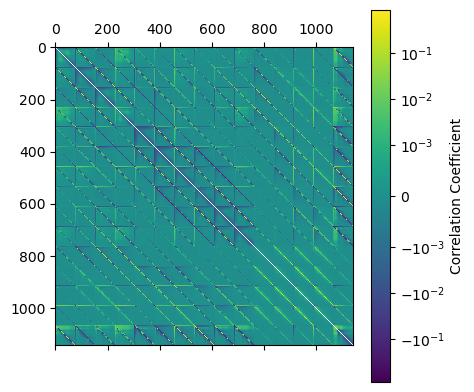

In [12]:
final_cov_reg = regularize_covariance(final_covariance)  # Create a copy of the final covariance matrix   
final_corr = covariance_to_correlation(final_cov_reg)  # Create a copy of the final covariance matrix


print(max(final_corr.flatten()))

np.fill_diagonal(final_corr, np.nan)  # Set the diagonal to zero to focus on correlations

plt.figure(figsize=(10, 8))
plt.matshow(final_corr, cmap='viridis', norm=SymLogNorm(linthresh=1e-3))
plt.colorbar(label='Correlation Coefficient')